In [1]:
### Imports ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import spectral.io.envi as envi
from tqdm.contrib import itertools
from time import sleep
from spectral import imshow, view_cube

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
### Constants ###
h = 6.626e-34 # Planck's constant
c = 299792458 # Speed of light
k = 1.380649e-23 # Boltzmann constant
b = 2.89777e-3 # Wien's constant

# Functions

In [3]:
def blackbody(l, T, e, offset=0):
    """Blackbody radiation equation
    Input: l: wavelength, T: temperature, e: emissivity, 
            offset: used in fitting to account for stray light in the data
    Output: intensity of a blackbody at the given parameters"""
    return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset

In [4]:
def construct_raw(folder_path):
    """ Constructs the paths to each of the relevant data files
    Input: path to hyperspectral data folder
    Output: list of paths to [raw hdr, raw raw, white reference hdr, white reference raw, 
                            dark reference hdr, dark reference raw, frame index file] """
    print("Constructing paths...")
    retval = []
    retval.append(folder_path + "/raw.hdr")
    retval.append(folder_path + "/raw")
    retval.append(folder_path + "/whiteReference.hdr")
    retval.append(folder_path + "/whiteReference")
    retval.append(folder_path + "/darkReference.hdr")
    retval.append(folder_path + "/darkReference")
    retval.append(folder_path + "/frameIndex.txt")
    return retval

In [5]:
def construct_data(folder_path):
    """ Constructs the paths to each of the relevant data files
    Input: path to hyperspectral data folder
    Output: list of paths to [raw hdr, raw raw, white reference hdr, white reference raw, 
                            dark reference hdr, dark reference raw, frame index file] """
    print("Constructing paths...")
    retval = []
    retval.append(folder_path + "/data.hdr")
    retval.append(folder_path + "/data")
    retval.append(folder_path + "/whiteReference.hdr")
    retval.append(folder_path + "/whiteReference")
    retval.append(folder_path + "/darkReference.hdr")
    retval.append(folder_path + "/darkReference")
    retval.append(folder_path + "/frameIndex.txt")
    return retval

In [6]:
def load_data(paths, quiet=False):
    """Input: paths list generated by (or in format of) construct_paths
    Output: hyperspectral tensor corrected by the white and dark references"""
    print("Loading data...")
    try:
        data_ref = envi.open(paths[0], paths[1])
        white_ref = envi.open(paths[2], paths[3])
        dark_ref = envi.open(paths[4], paths[5])

        white_tensor = np.array(white_ref.load())
        dark_tensor = np.array(dark_ref.load())
        data_tensor = np.array(data_ref.load())
    except:
        print("Load failed, waiting 30 seconds...")
        sleep(30)
        return "FAIL"

    corrected_data = np.divide(
        np.subtract(data_tensor, dark_tensor),
        np.subtract(white_tensor, dark_tensor))

    if not quiet:
        print(corrected_data)
    return corrected_data

In [7]:
def get_bands(paths, quiet=False):
    """Input: paths list generated by (or in format of) construct_paths
    Output: (Array of wavelength bands, wavelength units string)"""
    print("Getting wavelength bands...")
    file = open(paths[0], 'r')
    text = file.read()

    start_id = "\nwavelength = {\n"
    start_index = text.find(start_id) + len(start_id)
    end_id = "\n}\n;AOI height"
    end_index = text.find(end_id)
    wavelengths = text[start_index:end_index]
    wavelengths = np.array(wavelengths.split("\n,"), dtype=np.float32)

    units_id = "wavelength units = "
    units_index = text.find(units_id) + len(units_id)
    units = text[units_index:text.find(start_id)]

    if not quiet:
        print(f"Units = {units}")
        print(f"Number wavelengths = {len(wavelengths)}")
        print(f"Wavelengths: {wavelengths}")
        print(f"Removing wavelengths over 950 nm...")

    # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
    # amplifies intensities at those wavelengths, so we wish to ignore them in 
    # the fitting
    wavelengths = wavelengths[:339]

    return wavelengths

In [8]:
def compress_horiz_slice(data, start_idx, end_idx):
    return np.array([np.divide(np.sum(data[:,start_idx:end_idx,:],axis=1), 
                     end_idx-start_idx)])

def shrink_image(image, chunk_size=10, quiet=False):
    """Blurs an image to reduce it's size
    Input: chunk_size representing the number of pixels to average
    Output: the blurred image"""
    for itera in range(2):
        horiz_slices = []
        for i in range(image.shape[1] // chunk_size):
            start_idx = i * chunk_size
            end_idx = (i + 1) * chunk_size
            if end_idx < image.shape[1]:
                horiz_slices.append(compress_horiz_slice(image, start_idx, end_idx))
            elif start_idx == image.shape[1]:
                continue
            else:
                horiz_slices.append(compress_horiz_slice(image, start_idx, image.shape[1]))

        image = np.concatenate(tuple(horiz_slices), axis=0)

    return image

In [9]:
def fit_spectrum(spectrum, quiet=False, check_units=True):
    """Fits the selected spectrum
    Input: None (uses global variables)
    Output: Fitted parameters, final least squares cost"""
    if check_units:
        print("\nIf this test fails, check lower in this function to adjust wavelenght unit conversion to m")
        print("Checking that units are nm... ", end="")
        assert(units == "nm")
        print("Passed")
    if not quiet:
        print("Fitting spectrum...")

    # params = [a0, a1, a2, offset, T]
    params0 = np.array([1, 1, 1, 0.1, 1000])
    def intensity(params, l):
        e = params[0] + (params[1] * l) + (params[2] * l**2)
        return blackbody(l, params[4], e, params[3])
    
    def residuals(params):
        result = []
        for i in range(len(wavelengths)):
            Si = intensity(params, wavelengths[i] * 1e-9) # assuming units are nm
            St = spectrum[i]
            result.append(Si - St)
        return np.array(result)

    result = least_squares(residuals, params0)

    if not quiet:
        yfit = []
        for l in wavelengths:
            yfit.append(intensity(result.x, l * 1e-9))

        plt.figure(figsize=(5,5))
        plt.scatter(wavelengths, spectrum, s=5)
        plt.scatter(wavelengths, yfit, s=5)
        plt.title(f"Fitted Spectrum for Position ({pixel[0]}, {pixel[1]})", fontsize=15)
        plt.xlabel(f"Wavelength [{units}]", fontsize=12)
        plt.xticks(fontsize=10)
        plt.ylabel("Intensity [arb. units]", fontsize=12)
        plt.yticks([])
        plt.legend(["Actual", "Fitted"], fontsize=10)
        plt.show()

    return result.x, result.cost

# Raw

In [10]:
folder = "./2024_08_05_16_07_27"

In [11]:
paths = construct_raw(folder)
image = load_data(paths, quiet=True)
wavelengths = get_bands(paths, quiet=True)

Constructing paths...
Loading data...
Getting wavelength bands...


/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_23964/3065833879.py:18: RuntimeWarning: divide by zero encountered in divide
  corrected_data = np.divide(
/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_23964/3065833879.py:18: RuntimeWarning: invalid value encountered in divide
  corrected_data = np.divide(


/Users/namanparikh/opt/anaconda3/envs/openmsi/lib/python3.9/site-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.013052936643362045, 0.13462743163108826]
    G: [-0.013052936643362045, 0.13462743163108826]
    B: [-0.013052936643362045, 0.13462743163108826]

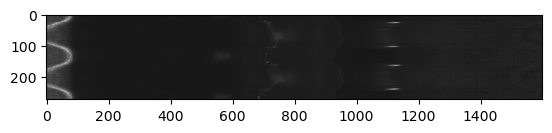

In [12]:
imshow(image, (100, 100, 100))

### Left thing

In [13]:
left = image[:80,:100,:]

ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0002568053314462304, 0.13462743163108826]
    G: [0.0002568053314462304, 0.13462743163108826]
    B: [0.0002568053314462304, 0.13462743163108826]

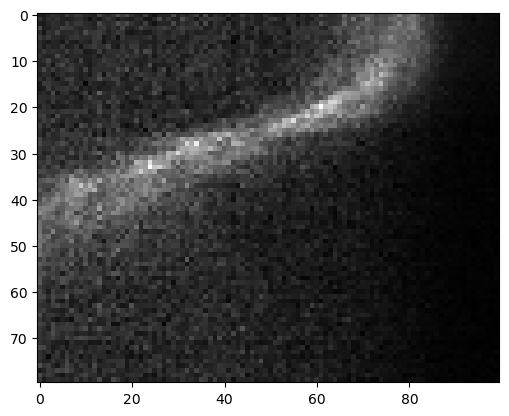

In [14]:
imshow(left, (100,100,100))

In [15]:
left.size / 371

8000.0

In [ ]:
temp_arr = np.zeros((left.shape[0], left.shape[1]))
for (i,j) in itertools.product(range(left.shape[0]), range(left.shape[1])):
    # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
    # amplifies intensities at those wavelengths, so we wish to ignore them in 
    # the fitting
    spectrum = left[i][j][:339]
    try:
        result, cost = fit_spectrum(spectrum, quiet=True, check_units=False)
        temp_arr[i][j] = result[-1]
    except: temp_arr[i][j] = -1

  0%|          | 0/8000 [00:00<?, ?it/s]

Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

/var/folders/mp/t1mxzpdx7k3522x6km17zjf40000gn/T/ipykernel_23964/3705668461.py:6: RuntimeWarning: overflow encountered in exp
  return (e * ((2 * h * c**2) / l**5) * (1 / (np.exp((h * c) / (l * k * T)) - 1))) + offset


### Right Thing

In [ ]:
right_shrunk = shrink_image(image[:,1050:1200,:], chunk_size=2)

In [ ]:
imshow(right_shrunk, (100, 100, 100))

In [ ]:
right_shrunk.size / 371

In [ ]:
# temp_arr = np.zeros((right_shrunk.shape[0], right_shrunk.shape[1]))
# for (i,j) in itertools.product(range(right_shrunk.shape[0]), range(right_shrunk.shape[1])):
#     # [:339] removes wavelengths 950 to 1000 nm since stray laser light 
#     # amplifies intensities at those wavelengths, so we wish to ignore them in 
#     # the fitting
#     spectrum = right_shrunk[i][j][:339]
#     try:
#         result, cost = fit_spectrum(spectrum, quiet=True, check_units=False)
#         temp_arr[i][j] = result[-1]
#     except: temp_arr[i][j] = -1

# Data